In [59]:
import os
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [60]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/data/Guava thermal Images/TI IMAGES"

In [62]:
def load_images_from_folder(dataset_path, categories):
    images_by_category = {category: [] for category in categories}
    for day_folder in os.listdir(dataset_path):
        day_folder_path = os.path.join(dataset_path, day_folder)
        if os.path.isdir(day_folder_path):
            for category in categories:
                category_folder_path = os.path.join(day_folder_path, category)
                if os.path.exists(category_folder_path):

                    for filename in os.listdir(category_folder_path):
                            image_path = os.path.join(day_folder_path, category, filename)
                            images_by_category[category].append(image_path)
    return images_by_category

In [63]:
categories = ["HALFMATURE", "IMMATURE", "MATURE"]
images_by_category = load_images_from_folder(dataset_path, categories)

In [64]:
def categorize_images(images_by_category):
    half_mature = []
    immature = []
    mature = []
    healthy = []

    for category, sub_paths in images_by_category.items():
        for sub_path in sub_paths:
            if "HEALTHY" in sub_path:
                healthy.append(sub_path)
            elif "HALFMATURE" in sub_path:
                half_mature.append(sub_path)
            elif "IMMATURE" in sub_path:
                immature.append(sub_path)
            elif "MATURE" in sub_path:
                mature.append(sub_path)


    return half_mature, immature, mature, healthy


In [65]:
half_mature, immature, mature, healthy = categorize_images(images_by_category)

In [66]:
def load_images_with_labels(folder_paths, label, max_images_per_class=None):
    images = []
    labels = []
    min_images_per_class = float('inf')
    for folder_path in folder_paths:
        image_count = 0
        for filename in os.listdir(folder_path):
            if  image_count == max_images_per_class:
                return images, labels, min_images_per_class
            img_path = os.path.join(folder_path, filename)
            # Read the image
            img = cv2.imread(img_path)
            # img = cv2.resize(img, (250, 250))
            images.append(img)
            labels.append(label)
            image_count += 1
        min_images_per_class = min(min_images_per_class, image_count)

    return images, labels, min_images_per_class

In [67]:
max_images_per_class = 15

In [68]:
half_mature_images, half_mature_labels, min_images_per_class = load_images_with_labels(half_mature, "HALFMATURE", max_images_per_class)
immature_images, immature_labels, _ = load_images_with_labels(immature, "IMMATURE", max_images_per_class)
mature_images, mature_labels, _ = load_images_with_labels(mature, "MATURE", max_images_per_class)
healthy_images, healthy_labels, _ = load_images_with_labels(healthy, "HEALTHY", max_images_per_class)

In [69]:
len(half_mature_images)

15

In [70]:
all_images = np.concatenate([half_mature_images, immature_images, mature_images, healthy_images])
all_labels = np.concatenate([half_mature_labels, immature_labels, mature_labels, healthy_labels])

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(all_images))
all_images_shuffled = all_images[shuffle_indices]
all_labels_shuffled = all_labels[shuffle_indices]

In [58]:
random_indices = random.sample(range(len(all_images_shuffled)), 5)

# Plot 5 randomly selected images with labels
plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(all_images_shuffled[idx])
    plt.title(all_labels_shuffled[idx])
    plt.axis('off')
plt.show()

NameError: name 'random' is not defined

In [37]:
print("Total images:", len(all_images_shuffled))
print("Total labels:", len(all_labels_shuffled))
print("Minimum images per class:", min_images_per_class)

Total images: 60
Total labels: 60
Minimum images per class: inf


SVM

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [48]:
all_images_shuffled_flattened = all_images_shuffled.reshape(all_images_shuffled.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(all_images_shuffled_flattened, all_labels_shuffled, test_size=0.2, random_state=42)


In [49]:
svm_classifier = SVC(kernel='linear', random_state=42)

In [50]:
# Train the classifier
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [51]:
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

  HALFMATURE       1.00      1.00      1.00         7
     HEALTHY       1.00      1.00      1.00         2
    IMMATURE       1.00      1.00      1.00         1
      MATURE       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [56]:
conf_matrix = confusion_matrix(y_test, y_pred)

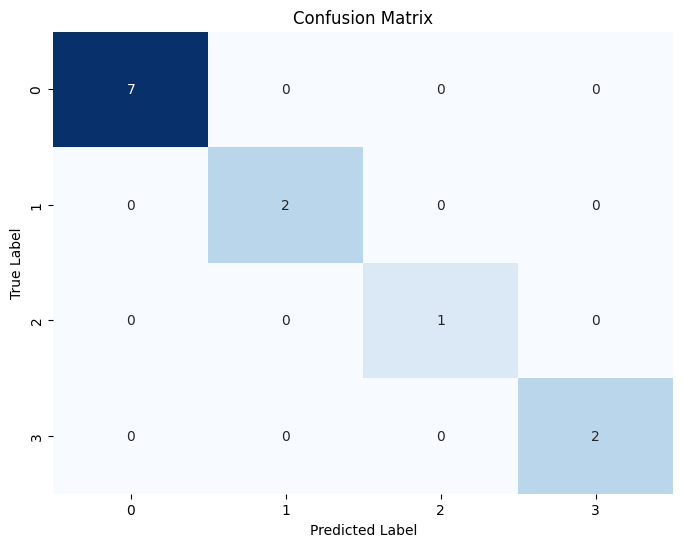

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

ANN

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [39]:
image_shape = all_images_shuffled[0].shape
X_train_reshaped = all_images_shuffled.reshape(all_images_shuffled.shape[0], *image_shape)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_train_reshaped, all_labels_shuffled, test_size=0.2, random_state=42)

In [47]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [43]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(all_labels_shuffled)), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

In [44]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node sparse_categorical_crossentropy/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-45-5984067494bc>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5725, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 2303, in cast

2 root error(s) found.
  (0) UNIMPLEMENTED:  Cast string to int64 is not supported
	 [[{{node sparse_categorical_crossentropy/Cast}}]]
  (1) CANCELLED:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_2617]